# Pupil preprocessing

A tutorial by Jan Willem de Gee (jwdegee@gmail.com) and Tomas Knapen (tknapen@gmail.com)

In [ ]:
from __future__ import division
import numpy as np
import scipy as sp

import matplotlib

import matplotlib.pyplot as pl
%matplotlib inline 

import seaborn as sn
sn.set(style="ticks")

# extra dependencies of this notebook, for data loading and fitting of kernels
import pandas as pd
from lmfit import minimize, Parameters, Parameter, report_fit

import sys
import os
workingDir = os.getcwd()[:-5]
sys.path.append(workingDir)

import FIRDeconvolution


ModuleNotFoundError: No module named 'FIRDeconvolution'

### Load data
Let's load some raw pupil data, sampled at 1000 Hz. We also load the times at which blinks and saccades occurred. 

In [ ]:
sample_rate = 1000.0
eye_dict = pd.read_csv('data/eye_dict.csv')
blink_dict = pd.read_csv('data/blink_dict.csv')
sac_dict = pd.read_csv('data/sac_dict.csv')

# variables to work with:
start_time = eye_dict.timepoints[0]
timepoints = eye_dict.timepoints - start_time
pupil = eye_dict.pupil
blink_starts = np.array(blink_dict.start_timestamp - start_time, dtype=int)
blink_ends = np.array(blink_dict.end_timestamp - start_time, dtype=int)
sac_starts = np.array(sac_dict.start_timestamp - start_time, dtype=int)
sac_ends = np.array(sac_dict.end_timestamp - start_time, dtype=int)

Let's plot the raw pupil timeseries:

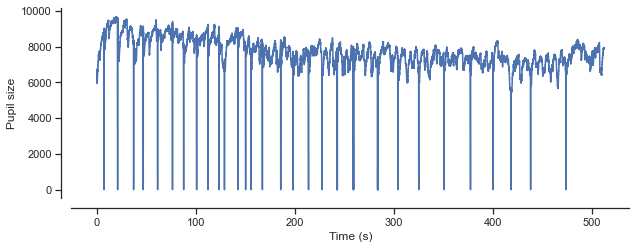

In [ ]:
x = np.arange(timepoints.shape[0]) / sample_rate
f = pl.figure(figsize = (10,3.5))
pl.plot(x, pupil)
pl.xlabel('Time (s)')
pl.ylabel('Pupil size')
sn.despine(offset=10)

The periods where the timeseries drop to 0 correspond to blinks. Let's linearly interpolate these blinks.

In [ ]:
margin = 100 # ms
margin = int((margin*sample_rate)/1000)
pupil_interpolated = np.array(pupil.copy())
for b in xrange(blink_starts.shape[0]):
    blink_start =  np.where(timepoints==blink_starts[b])[0][0]-margin+1
    blink_end =  np.where(timepoints==blink_ends[b])[0][0]+margin+1
    interpolated_signal = np.linspace(pupil_interpolated[blink_start], 
                                      pupil_interpolated[blink_end],
                                      blink_end-blink_start,
                                      endpoint=False)
    pupil_interpolated[blink_start:blink_end] = interpolated_signal
f = pl.figure(figsize = (10,3.5))
pl.plot(x, pupil_interpolated)
pl.xlabel('Time (s)')
pl.ylabel('Pupil size')
sn.despine(offset=10)

NameError: name 'xrange' is not defined

To see what happened, let's zoom in on one interpolated blink:

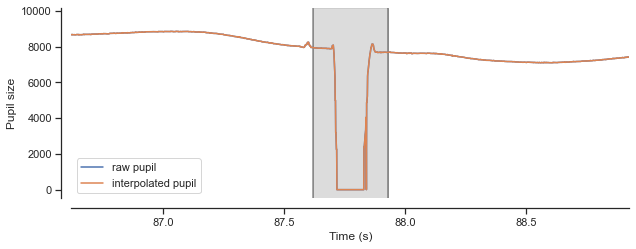

In [ ]:
f = pl.figure(figsize = (10,3.5))

pl.axvspan((-margin + blink_starts[7]) / sample_rate, (margin + blink_ends[7]) / sample_rate, alpha=0.15, color='k')
pl.axvline( (-margin + blink_starts[7]) / sample_rate, color = 'k', alpha = 0.5, lw = 1.5)
pl.axvline( (margin + blink_ends[7]) / sample_rate, color = 'k', alpha = 0.5, lw = 1.5)

pl.plot(x, pupil, label='raw pupil')
pl.plot(x, pupil_interpolated, label='interpolated pupil')

pl.xlim((-margin + blink_starts[7] - 1000) / sample_rate, 
     (margin + blink_ends[7] + 1000) / sample_rate)

pl.xlabel('Time (s)')
pl.ylabel('Pupil size')
pl.legend(loc=3)

sn.despine(offset=10)

Let's filter blink interpolated pupil timeseries now. We'll construct a low pass (<10Hz), and a band-pass (0.01-10Hz) signal. And again, let's plot the results.

In [ ]:
hp = 0.01
lp = 10.0


# High pass:
hp_cof_sample = hp /  (sample_rate / 2)
bhp, ahp = sp.signal.butter(3, hp_cof_sample, btype='high')
pupil_interpolated_hp = sp.signal.filtfilt(bhp, ahp, pupil_interpolated)
# Low pass:
lp_cof_sample = lp / (sample_rate / 2)

blp, alp = sp.signal.butter(3, lp_cof_sample)
pupil_interpolated_lp = sp.signal.filtfilt(blp, alp, pupil_interpolated)
# Band pass:
pupil_interpolated_bp = sp.signal.filtfilt(blp, alp, pupil_interpolated_hp)

f = pl.figure(figsize = (10,3.5))

pl.plot(x, pupil_interpolated_lp, label='low pass')
pl.plot(x, pupil_interpolated_bp, label='band pass')
pl.xlabel('Time (s)')
pl.ylabel('Pupil size')
pl.legend()

sn.despine(offset=10)

AttributeError: module 'scipy' has no attribute 'signal'

The band-pass filtered signal we can use now to estimate pupil responses to blinks and saccades. You can think of these of simple event related averages. However, to account for temporally adjacent event, and hence overlapping responses (due to slow pupil IRF), here we will rely on deconvolution. 

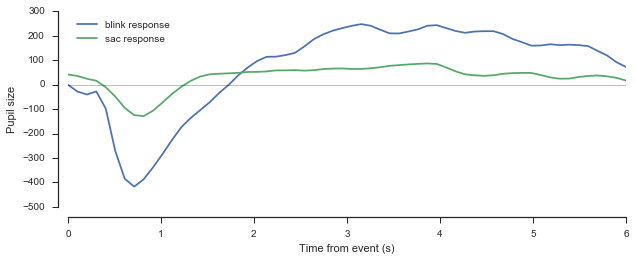

In [8]:
downsample_rate = 100
new_sample_rate = sample_rate / downsample_rate
interval = 6

# events:
events = [(blink_ends / sample_rate), 
          (sac_ends / sample_rate)]

# compute blink and sac kernels with deconvolution (on downsampled timeseries):
a = FIRDeconvolution.FIRDeconvolution(signal=sp.signal.decimate(pupil_interpolated_bp, downsample_rate, 1), 
                         events=events, event_names=['blinks', 'sacs'], sample_frequency=new_sample_rate, 
                         deconvolution_frequency=new_sample_rate, deconvolution_interval=[0,interval],)
a.create_design_matrix()
a.regress()
a.betas_for_events()
blink_response = np.array(a.betas_per_event_type[0]).ravel()
sac_response = np.array(a.betas_per_event_type[1]).ravel()

# baseline the kernels:
blink_response = blink_response - blink_response[0].mean()
sac_response = sac_response - blink_response[0].mean()

# plot:
x = np.linspace(0, interval, len(blink_response))

f = pl.figure(figsize = (10,3.5))

pl.plot(x, blink_response, label='blink response')
pl.plot(x, sac_response, label='sac response')
pl.xlabel('Time from event (s)')
pl.ylabel('Pupil size')
pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
pl.legend(loc=2)
sn.despine(offset=10)

Let's fit kernels to these:

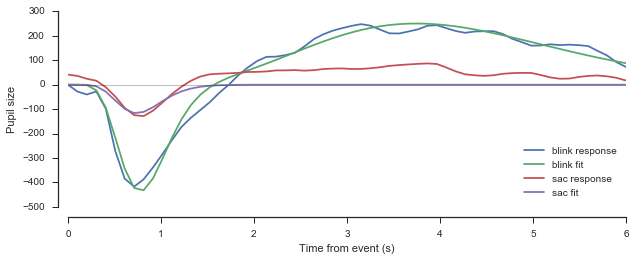

In [9]:
def single_pupil_IRF(params, x):
    s1 = params['s1']
    n1 = params['n1']
    tmax1 = params['tmax1']
    return s1 * ((x**n1) * (np.e**((-n1*x)/tmax1)))

def single_pupil_IRF_ls(params, x, data):
    s1 = params['s1'].value
    n1 = params['n1'].value
    tmax1 = params['tmax1'].value
    model = s1 * ((x**n1) * (np.e**((-n1*x)/tmax1)))
    return model - data

def double_pupil_IRF(params, x):
    s1 = params['s1']
    s2 = params['s2']
    n1 = params['n1']
    n2 = params['n2']
    tmax1 = params['tmax1']
    tmax2 = params['tmax2']
    return s1 * ((x**n1) * (np.e**((-n1*x)/tmax1))) + s2 * ((x**n2) * (np.e**((-n2*x)/tmax2)))

def double_pupil_IRF_ls(params, x, data):
    s1 = params['s1'].value
    s2 = params['s2'].value
    n1 = params['n1'].value
    n2 = params['n2'].value
    tmax1 = params['tmax1'].value
    tmax2 = params['tmax2'].value
    model = s1 * ((x**n1) * (np.e**((-n1*x)/tmax1))) + s2 * ((x**n2) * (np.e**((-n2*x)/tmax2)))
    return model - data

# create a set of Parameters
params = Parameters()
params.add('s1', value=-1, min=-np.inf, max=-1e-25)
params.add('s2', value=1, min=1e-25, max=np.inf)
params.add('n1', value=10, min=9, max=11)
params.add('n2', value=10, min=8, max=12)
params.add('tmax1', value=0.9, min=0.5, max=1.5)
params.add('tmax2', value=2.5, min=1.5, max=4)

# do fit, here with powell method:
blink_result = minimize(double_pupil_IRF_ls, params, method='powell', args=(x, blink_response))
blink_kernel = double_pupil_IRF(blink_result.params, x)
sac_result = minimize(single_pupil_IRF_ls, params, method='powell', args=(x, sac_response))
sac_kernel = single_pupil_IRF(sac_result.params, x)

# plot:
f = pl.figure(figsize = (10,3.5))

pl.plot(x, blink_response, label='blink response')
pl.plot(x, blink_kernel, label='blink fit')
pl.plot(x, sac_response, label='sac response')
pl.plot(x, sac_kernel, label='sac fit')

pl.xlabel('Time from event (s)')
pl.ylabel('Pupil size')
pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
pl.legend(loc=4)
sn.despine(offset=10)

Now, with a GLM let's regress these responses to blinks and saccades from our pupil timeseries. 

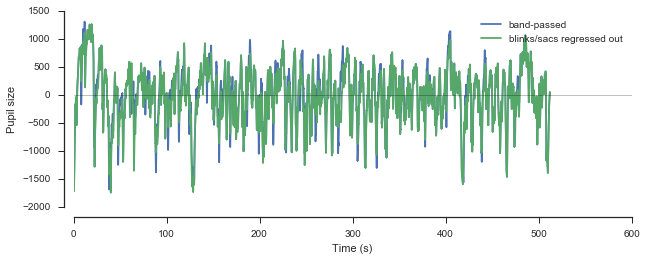

In [10]:
# upsample:
x = np.linspace(0, interval, interval*sample_rate)
blink_kernel = double_pupil_IRF(blink_result.params, x)
sac_kernel = double_pupil_IRF(sac_result.params, x)

# regressors:
blink_reg = np.zeros(len(pupil))
blink_reg[blink_ends] = 1
blink_reg_conv = sp.signal.fftconvolve(blink_reg, blink_kernel, 'full')[:-(len(blink_kernel)-1)]
sac_reg = np.zeros(len(pupil))
sac_reg[blink_ends] = 1
sac_reg_conv = sp.signal.fftconvolve(sac_reg, sac_kernel, 'full')[:-(len(sac_kernel)-1)]
regs = [blink_reg_conv, sac_reg_conv]

# GLM:
design_matrix = np.matrix(np.vstack([reg for reg in regs])).T
betas = np.array(((design_matrix.T * design_matrix).I * design_matrix.T) * np.matrix(pupil_interpolated_bp).T).ravel()
explained = np.sum(np.vstack([betas[i]*regs[i] for i in range(len(betas))]), axis=0)

# clean pupil:
pupil_clean_bp = pupil_interpolated_bp - explained

# plot:
f = pl.figure(figsize = (10,3.5))

x = np.arange(timepoints.shape[0]) / sample_rate
pl.plot(x, pupil_interpolated_bp, label='band-passed')
pl.plot(x, pupil_clean_bp, label='blinks/sacs regressed out')

pl.xlabel('Time (s)')
pl.ylabel('Pupil size')
pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
pl.legend()
sn.despine(offset=10)

Finally, let's add back the slow drift, which is meaningful part of the signal!

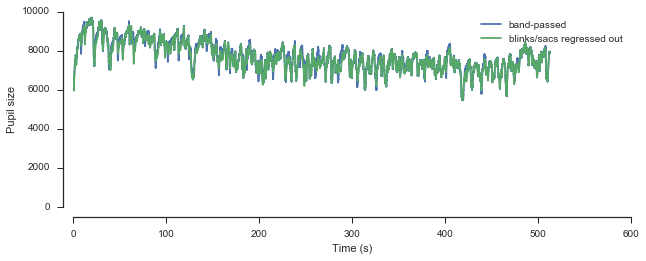

In [11]:
pupil_clean_lp = pupil_clean_bp + (pupil_interpolated_lp-pupil_interpolated_bp)

f = pl.figure(figsize = (10,3.5))

x = np.arange(timepoints.shape[0]) / sample_rate
pl.plot(x, pupil_interpolated, label='band-passed')
pl.plot(x, pupil_clean_lp, label='blinks/sacs regressed out')

pl.xlabel('Time (s)')
pl.ylabel('Pupil size')
pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
pl.legend()
sn.despine(offset=10)

#### Preprocessing done
From here, one can do standard epoch-based regression and averaging analyses. 